#import&installs

In [1]:
!pip install missforest lightgbm xgboost joblib
!pip install --upgrade scikit-learn
!pip install --upgrade catboost
!pip install missforest
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from missforest import MissForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Join Previous Application Table

In [3]:
prev_app = pd.read_csv('/content/drive/MyDrive/dataset/home-credit-default-risk/previous_application.csv')
app_train = pd.read_csv('/content/drive/MyDrive/dataset/home-credit-default-risk/application_train.csv')


In [4]:
aggregated_previous = prev_app.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT': 'sum',
    #sum: إجمالي قيمة القروض التي طلبها العميل
    #يساعد في معرفة حجم القروض التي يتعامل معها العميل بشكل عام، وهل يميل لطلب قروض كبيرة أو صغيرة.

    'AMT_ANNUITY': 'mean',
    #mean: متوسط قيمة الأقساط السنوية المطلوبة من العميل في طلباته السابقة.
    # يُستخدم لفهم قدرة العميل على الالتزام بدفع الأقساط، مما يمكن أن يساعد في تقييم الجدارة الائتمانية.

    'DAYS_DECISION': 'min',
    #min: أقرب تاريخ (منذ اليوم الحالي) اتخذ فيه العميل قراراً بشأن طلب قرض.
    # يُستخدم لفهم مدى استمرارية العميل في طلب القروض، وهل طلب القروض حديث أو قديم.

    'CNT_PAYMENT': 'mean',
    # mean: متوسط عدد الأقساط لكل قرض في طلبات العميل السابقة.
    #يساعد في فهم مدة القروض التي يفضلها العميل. على سبيل المثال، هل يميل العميل لاختيار قروض طويلة الأجل أم قصيرة الأجل؟

    'RATE_DOWN_PAYMENT': 'mean',
    #mean: متوسط نسبة الدفعة الأولى التي دفعها العميل مقارنة بإجمالي قيمة القرض في طلباته السابقة.
    #يُظهر مدى قدرة العميل على دفع مقدم كبير عند طلب القروض، وهو مؤشر على الجدارة الائتمانية.

    'AMT_GOODS_PRICE': 'mean',
    # mean: متوسط سعر البضائع أو المنتجات التي طلب العميل الحصول عليها عبر القروض السابقة.
    #لمعرفة نمط استهلاك العميل وهل يميل لشراء منتجات ذات قيمة مرتفعة أو متوسطة.

    'AMT_APPLICATION': 'mean'
    #mean: متوسط المبلغ الذي طلبه العميل في طلباته السابقة.
    #لفهم مستوى القروض التي يطلبها العميل في المتوسط.
}).reset_index()

# Flatten the column names (multi-index created by aggregation)

# Merge with the main table
merged_table1 = pd.merge(app_train, aggregated_previous, on='SK_ID_CURR', how='left')

# Save the result
merged_table1.to_csv('merged_table_with_prev_app.csv', index=False)


#Join with installments_payment

In [5]:
isnt_pay = pd.read_csv('/content/drive/MyDrive/dataset/home-credit-default-risk/installments_payments.csv')


In [6]:
# Perform aggregation on important columns in installments_payments
aggregated_installments = isnt_pay.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': 'mean',
    #mean: يقوم بحساب المتوسط لجميع الأقساط المدفوعة عبر جميع السجلات

    'AMT_PAYMENT': 'mean',
    #mean: حساب متوسط المدفوعات عبر جميع السجلات. هذه المعلومة توفر فكرة عن مبلغ المدفوعات المعتاد.

    'NUM_INSTALMENT_VERSION': 'max',
    #max:أحدث إصدار لرقم القسط تم استخدامه. قد يكون هذا مفيدًا لفهم آخر تغيير في شروط الدفع.

    'NUM_INSTALMENT_NUMBER': 'max',
    #max: مجموع عددد الاقساط
    'DAYS_INSTALMENT': 'mean',
    #mean :  حساب متوسط تواريخ الأقساط في الأيام.
    #هذه المعلومة تفيد في معرفة الوقت المعتاد بين الأقساط بيأخر ولا بيسدد بدري
    'DAYS_ENTRY_PAYMENT': 'mean'
    #mean: حساب متوسط الأيام بين تاريخ الدفع ووقت الدفع الفعلي.
    #يساعد في معرفة المدة الزمنية التي تم تأخير الدفع فيها.
}).reset_index()

# Flatten MultiIndex in columns after aggregation
# aggregated_installments.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in aggregated_installments.columns]

# Merge with the merged_table1
merged_table2 = pd.merge(merged_table1, aggregated_installments, on='SK_ID_CURR', how='left')

# Display the result
print(merged_table2.head())
merged_table2.to_csv('merged_table_with_isntall_payment.csv', index=False)



   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0               Y             0          202500.0      406597.5   
1               N             0          270000.0     1293502.5   
2               Y             0           67500.0      135000.0   
3               Y             0          135000.0      312682.5   
4               Y             0          121500.0      513000.0   

   AMT_ANNUITY_x  ...  CNT_PAYMENT RATE_DOWN_PAYMENT AMT_GOODS_PRICE_y  \
0        24700.5  ...    24.000000          0.000000         179055.00   
1        35698.5  ...    10.000000

#Join with credit card balance

In [7]:
cred_card_bal = pd.read_csv('/content/drive/MyDrive/dataset/home-credit-default-risk/credit_card_balance.csv')


In [8]:
# Perform aggregation on important columns in credit_card_balance
aggregated_credit_card = cred_card_bal.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': 'mean',                # حساب متوسط رصيد مستحق

    'AMT_CREDIT_LIMIT_ACTUAL':  'max',           # حساب أقصى حد رصيد فعلي

    'AMT_DRAWINGS_ATM_CURRENT': 'mean',   # حساب متوسط سحب من أجهزة الصراف الآلي

    'AMT_DRAWINGS_CURRENT': 'mean',       # حساب متوسط سحب نقدي

    'AMT_DRAWINGS_OTHER_CURRENT': 'mean', # حساب متوسط سحب من أنواع أخرى

    'AMT_DRAWINGS_POS_CURRENT': 'mean',   # حساب متوسط سحب من نقاط البيع

    'AMT_INST_MIN_REGULARITY': 'mean',                    # حساب متوسط الحد الأدنى المنتظم للمدفوعات

    'AMT_PAYMENT_CURRENT': 'mean',        # حساب متوسط دفعة تم دفعها

    'AMT_PAYMENT_TOTAL_CURRENT': 'mean',  # حساب متوسط، مجموع، وأقصى دفعة إجمالية

    'AMT_RECEIVABLE_PRINCIPAL': 'mean',   # حساب متوسط، مجموع، وأقصى المبلغ المستحق

    'AMT_RECIVABLE': 'sum',              # حساب  مجموع المبالغ المستحقة

    'AMT_TOTAL_RECEIVABLE':  'sum',       # حساب متوسط، مجموع، وأقصى المبالغ المستحقة الإجمالية

    'CNT_DRAWINGS_ATM_CURRENT': 'sum',                    # حساب مجموع عدد السحوبات من أجهزة الصراف الآلي

    'CNT_DRAWINGS_CURRENT': 'sum',                        # حساب مجموع عدد السحوبات النقدية

    'CNT_DRAWINGS_OTHER_CURRENT': 'sum',                  # حساب مجموع عدد السحوبات من أنواع أخرى

    'CNT_DRAWINGS_POS_CURRENT': 'sum',                    # حساب مجموع عدد السحوبات من نقاط البيع

    'CNT_INSTALMENT_MATURE_CUM': 'sum',                   # حساب مجموع عدد الأقساط المستحقة

    'SK_DPD': 'max',                                     # حساب أكبر تأخير في الدفع

    'SK_DPD_DEF': 'max'                                  # حساب أكبر تأخير في الدفع مع التأخير المحدد
}).reset_index()

# Flatten MultiIndex in columns after aggregation
# aggregated_credit_card.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in aggregated_credit_card.columns]

# Merge with the merged_table1
merged_table3 = pd.merge(merged_table2, aggregated_credit_card, on='SK_ID_CURR', how='left')

# Display the result
print(merged_table3.head())
merged_table3.to_csv('merged_table_with_credit_card_balance.csv', index=False)


   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0               Y             0          202500.0      406597.5   
1               N             0          270000.0     1293502.5   
2               Y             0           67500.0      135000.0   
3               Y             0          135000.0      312682.5   
4               Y             0          121500.0      513000.0   

   AMT_ANNUITY_x  ...  AMT_RECEIVABLE_PRINCIPAL AMT_RECIVABLE  \
0        24700.5  ...                       NaN           NaN   
1        35698.5  ...                       NaN     

#Join with pos_cash_balance

In [9]:
pos_cash_bal = pd.read_csv('/content/drive/MyDrive/dataset/home-credit-default-risk/POS_CASH_balance.csv')


In [10]:
# Perform aggregation on important columns in pos_cash_balance
aggregated_pos_cash = pos_cash_bal.groupby('SK_ID_CURR').agg({
    'CNT_INSTALMENT': 'sum',         # مجموع عدد الأقساط المدفوعة
    'CNT_INSTALMENT_FUTURE': 'sum',  # مجموع عدد الأقساط المستقبلية

}).reset_index()

# Merge with the final_merged_table
merged_table4 = pd.merge(merged_table3, aggregated_pos_cash, on='SK_ID_CURR', how='left')

# Display the result
print(merged_table4.head())
merged_table4.to_csv('merged_table_with_pos_cash_balance.csv', index=False)

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0               Y             0          202500.0      406597.5   
1               N             0          270000.0     1293502.5   
2               Y             0           67500.0      135000.0   
3               Y             0          135000.0      312682.5   
4               Y             0          121500.0      513000.0   

   AMT_ANNUITY_x  ...  AMT_TOTAL_RECEIVABLE CNT_DRAWINGS_ATM_CURRENT  \
0        24700.5  ...                   NaN                      NaN   
1        35698.5  ...                 

# Join with Bureau

In [11]:
bureau = pd.read_csv('/content/drive/MyDrive/dataset/home-credit-default-risk/bureau.csv')


In [12]:
# Perform aggregation on important columns in bureau
aggregated_bureau = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM': 'sum',
    #sum: المجموع الكلي للمبالغ الائتمانية المعتمدة للعملاء عبر جميع الحسابات الائتمانية.

    'AMT_CREDIT_SUM_DEBT': 'sum',
    #sum: مجموع المبالغ المتبقية كديون على العميل عبر حساباته الائتمانية.

    'AMT_CREDIT_SUM_LIMIT': 'sum',
    #sum: مجموع الحد الائتماني المتاح عبر جميع الحسابات الائتمانية للعملاء.

    'AMT_CREDIT_SUM_OVERDUE': 'sum',
    #sum: مجموع المبالغ المتأخرة في الدفع عبر حسابات العميل الائتمانية.

    'CNT_CREDIT_PROLONG': 'sum',
    #sum: مجموع عدد التمديدات التي تم منحها على حسابات الائتمان.

    'AMT_ANNUITY': 'sum',
    #sum: المجموع الكلي للمبالغ السنوية المستحقة على العميل في حساباته الائتمانية.

}).reset_index()


# Merge with the final_merged_table
merged_table5 = pd.merge(merged_table4, aggregated_bureau, on='SK_ID_CURR', how='left')

# Display the result
print(merged_table5.head())
merged_table5.to_csv('merged_table_with_bureau.csv', index=False)

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0               Y             0          202500.0      406597.5   
1               N             0          270000.0     1293502.5   
2               Y             0           67500.0      135000.0   
3               Y             0          135000.0      312682.5   
4               Y             0          121500.0      513000.0   

   AMT_ANNUITY_x  ...  SK_DPD SK_DPD_DEF CNT_INSTALMENT CNT_INSTALMENT_FUTURE  \
0        24700.5  ...     NaN        NaN          456.0                 285.0   
1        35698.5  ..

In [13]:
data = merged_table5

In [62]:
data.shape

(307511, 162)

In [14]:
data['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


# Preprocessing

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np


def check_nulls(data):
    nulls = data.isnull().mean() * 100
    return nulls[nulls > 0]

def check_outliers(data):
    outliers = {}
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = {
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outliers': data[(data[col] < lower_bound) | (data[col] > upper_bound)].shape[0]
        }
    return outliers


def check_skewness(data, threshold=0.5):
    skewness = {}
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        skew = data[col].skew()
        if abs(skew) > threshold:
            skewness[col] = skew
    return skewness

# Step 1: Handle nulls with thresholds
def handle_nulls(data, threshold_drop=55, threshold_median=15):
    data = data.copy()
    for col in data.columns:
        null_percentage = data[col].isnull().mean() * 100

        if null_percentage > threshold_drop:
            data.drop(columns=col, inplace=True)
        elif null_percentage <= threshold_median:
            if data[col].dtype in ['float64', 'int64']:
                data[col] = data[col].fillna(data[col].median())
            else:
                data[col] = data[col].fillna(data[col].mode()[0])
    return data

# Step 2: Handle missing values using MissForest
#missforest
'''
def impute_missing(data):
    data = data.copy()
    # Encode categorical columns as integers before using MissForest
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        data[col] = data[col].astype('category').cat.codes

    missforest = MissForest()
    imputed_data = missforest.fit_transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns)
'''
#simpleimputer
from sklearn.impute import SimpleImputer

def impute_missing_simple(data):
    data = data.copy()
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns

    # Impute numerical columns
    num_imputer = SimpleImputer(strategy='median')
    data[numeric_cols] = num_imputer.fit_transform(data[numeric_cols])

    # Impute categorical columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

    return data

# Step 3: Drop repeated columns
def drop_repeated_columns(data, threshold=0.8):
    data = data.copy()
    for col in data.columns:
        if data[col].value_counts(normalize=True).iloc[0] > threshold:
            data.drop(columns=col, inplace=True)
    return data

# Step 4: Handle outliers
'''
def handle_outliers(data):
    data = data.copy()
    isolation_forest = IsolationForest(contamination=0.05, random_state=42)
    predictions = isolation_forest.fit_predict(data)
    data = data[predictions == 1]
    return data
'''
def handle_outliers(data):
    data = data.copy()
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping outliers
        data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

    return data

# Step 5: Handle skewness
def handle_skewness(data, threshold=0.5):
    data = data.copy()
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        skewness = data[col].skew()
        if abs(skewness) > threshold:
            data[col] = np.log1p(data[col] - data[col].min() + 1)
    return data

# Step 6: One-hot encoding
def one_hot_encode(data):
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(data[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))
    data = data.drop(columns=categorical_cols).reset_index(drop=True)
    data = pd.concat([data, encoded_df], axis=1)
    return data

# Step 7: Scaling
def scale_data(data):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)
    return pd.DataFrame(scaled, columns=data.columns)



# Step 8: Split into X and y
def split_data(data, target_column):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    return X, y




In [18]:
def preprocess_pipeline(data, target_column):
    # Separate target column before preprocessing
    y = data[target_column]
    X = data.drop(columns=[target_column])

    # فحص الـ nulls
    print("Checking for nulls:")
    nulls = check_nulls(X)
    print(nulls)

    # فحص الـ outliers
    print("Checking for outliers:")
    outliers = check_outliers(X)
    print(outliers)

    # فحص الـ skewness
    print("Checking for skewness:")
    skewness = check_skewness(X)
    print(skewness)

    # Handle nulls
    X = handle_nulls(X)
    print('Handle nulls finished')

    # Impute missing values
    X = impute_missing_simple(X)
    print(X.isna().sum())
    print('Impute missing values finished')

    # Drop repeated columns
    X = drop_repeated_columns(X)
    print('Drop repeated columns finished')

    # Handle outliers
    X = handle_outliers(X)
    print('Handle outliers finished')

    # Handle skewness
    X = handle_skewness(X)
    print('Handle skewness finished')

    # Encode categorical data
    X = one_hot_encode(X)
    print('One hot encoding finished')

    # Ensure only numeric data for scaling and dimensionality reduction
    numeric_data = X.select_dtypes(include=['float64', 'int64'])

    # Scale the data
    scaled_data = scale_data(numeric_data)
    print('Data scaling finished')


    # Return the preprocessed features and target
    return scaled_data, y


In [19]:

# Specify the target column
target_column = 'TARGET'

# Run the preprocessing pipeline
X, y = preprocess_pipeline(data, target_column)

# Verify the results
print("Processed Features Shape:", X.shape)
print("Target Shape:", y.shape)


Checking for nulls:
AMT_ANNUITY_x              0.003902
AMT_GOODS_PRICE_x          0.090403
NAME_TYPE_SUITE            0.420148
OWN_CAR_AGE               65.990810
OCCUPATION_TYPE           31.345545
                            ...    
AMT_CREDIT_SUM_DEBT       14.314935
AMT_CREDIT_SUM_LIMIT      14.314935
AMT_CREDIT_SUM_OVERDUE    14.314935
CNT_CREDIT_PROLONG        14.314935
AMT_ANNUITY               14.314935
Length: 107, dtype: float64
Checking for outliers:
{'SK_ID_CURR': {'lower_bound': -77850.0, 'upper_bound': 634138.0, 'outliers': 0}, 'CNT_CHILDREN': {'lower_bound': -1.5, 'upper_bound': 2.5, 'outliers': 4272}, 'AMT_INCOME_TOTAL': {'lower_bound': -22500.0, 'upper_bound': 337500.0, 'outliers': 14035}, 'AMT_CREDIT_x': {'lower_bound': -537975.0, 'upper_bound': 1616625.0, 'outliers': 6562}, 'AMT_ANNUITY_x': {'lower_bound': -10584.0, 'upper_bound': 61704.0, 'outliers': 7504}, 'AMT_GOODS_PRICE_x': {'lower_bound': -423000.0, 'upper_bound': 1341000.0, 'outliers': 14728}, 'REGION_POPULAT

In [20]:
import gc
gc.collect()


0

In [21]:
!free -h


               total        used        free      shared  buff/cache   available
Mem:            12Gi       7.9Gi       1.5Gi       1.0Mi       3.3Gi       4.5Gi
Swap:             0B          0B          0B


# Build & Evaluate

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
X.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('.', '_').replace('(', '').replace(')', '') for col in X.columns]

# Function to build models, evaluate metrics, and plot AUC-ROC curve
def build_and_evaluate_models(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models with class balancing
    models = {
        'XGBoost': xgb.XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
                                      eval_metric='logloss', random_state=42),
        'CatBoost': CatBoostClassifier(class_weights=[y_train.value_counts()[0] / y_train.value_counts()[1], 1],
                                        random_state=42, verbose=0)
    }

    # Initialize results dictionary
    results = {}

    # Initialize AUC plot
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Predict probabilities for AUC
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Predict class labels
        y_pred = model.predict(X_test)

        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        report = classification_report(y_test, y_pred)

        # Store results
        results[model_name] = {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'classification_report': report
        }

        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('ROC Curves for Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    return results




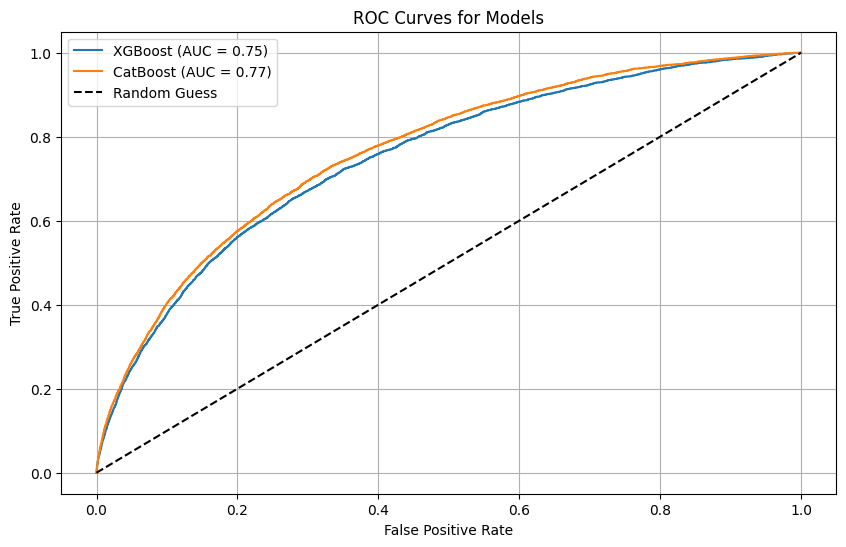

Model: XGBoost
Accuracy: 0.7464026145066094
AUC: 0.7509015946814241
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     56554
           1       0.18      0.61      0.28      4949

    accuracy                           0.75     61503
   macro avg       0.57      0.68      0.56     61503
weighted avg       0.89      0.75      0.80     61503


Model: CatBoost
Accuracy: 0.9195486399037446
AUC: 0.7653364169535093
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.67      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.79      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503




In [32]:
# Build and evaluate models
results = build_and_evaluate_models(X, y)

# Print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']}")
    print(f"AUC: {result['auc_score']}")
    print(f"Classification Report:\n{result['classification_report']}\n")